---

# Learn the basics - PyTorch tutorial

This notebook contains notes and code from the [Learn the Basics](https://docs.pytorch.org/tutorials/beginner/basics/intro.html) PyTorch tutorial from the official PyTorch documentation.


---

## **Table of Contents**

### [**0 - Quickstart**](#0---quickstart)

- [0.1 - Working with data](#01---working-with-data)
- [0.2 - Creating models](#02---creating-models)
- [0.3 - Optimizing the model parameters](#03---optimizing-the-model-parameters)
- [0.4 - Saving and loading models](#04---saving-and-loading-models)

### [**1 - Tensors**](#1---tensors)

- [1.1 - Initializing a tensor](#11---initializing-a-tensor)
- [1.2 - Attributes of a tensor](#12---attributes-of-a-tensor)
- [1.3 - Operations on tensors](#13---operations-on-tensors)
- [1.4 - Bridge with NumPy](#14---bridge-with-numpy)

### [**2 - `Datasets` and `DataLoaders`**](#2---datasets-and-dataloaders)

- [2.1 - Loading a dataset](#21---loading-a-dataset)
- [2.2 - Iterating and visualizing a dataset](#22---iterating-and-visualizing-a-dataset)
- [2.3 - Creating a custom dataset for your files](#23---creating-a-custom-dataset-for-your-files)
- [2.4 - Preparing your data for training with `DataLoaders`](#24---preparing-your-data-for-training-with-dataloaders)

### [**3 - Transforms**](#3---transforms)

### [**4 - Building neural networks**](#4---building-neural-networks)

- [4.1 - Getting a device for training](#41---getting-a-device-for-training)
- [4.2 - Defining the class](#42---defining-the-class)
- [4.3 - Model layers](#43---model-layers)
- [4.4 - `nn.Softmax`](#44---nnsoftmax)
- [4.5 - Model parameters](#45---model-parameters)

### [**5 - Automatic differentiation with `torch.autograd`**](#5---automatic-differentiation-with-torchautograd)

- [5.1 - Tensors, functions and computational graphs](#51---tensors-functions-and-computational-graphs)
- [5.2 - Computing gradients](#52---computing-gradients)

### [**6 - Optimizing model parameters**](#6---optimizing-model-parameters)

- [6.1 - Hyperparameters](#61---hyperparameters)
- [6.2 - The optimization loop](#62---the-optimization-loop)
- [6.3 - Loss functions](#63---loss-functions)
- [6.4 - Optimizers](#64---optimizers)
- [6.5 - Full implementation](#65---full-implementation)

### [**7 - Saving and loading models**](#7---saving-and-loading-models)


---

## 0 - Quickstart


### 0.1 - Working with data


Import the required modules.


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

Download training and test data from the FashionMNIST dataset.


In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Initialize data loaders.


In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### 0.2 - Creating Models


We can define a neural network in PyTorch by creating a class which inherits from `nn.Module`. Layers of the network are defined in the `__init__` function. We specify how data passes through the network in the `forward` function.


In [4]:
# Set device to MPS if available, otherwise CPU.
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using {device} device.")


# Define the model/
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

Using mps device.
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### 0.3 - Optimizing the model parameters


To train a model, we need a loss function and an optimizer.


In [5]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In each training loop, the model makes predictions on the training dataset, and backpropagates the prediction error to adjust the model's parameters.


In [6]:
def train(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        prediction = model(x)
        # Compute the error in the prediction.
        loss = loss_function(prediction, y)

        # Backpropagate the prediction error.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

We can check the model's performance against the test dataset to ensure that it is learning.


In [7]:
def test(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            prediction = model(x)
            test_loss += loss_function(prediction, y).item()
            correct += (prediction.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%; average loss: {test_loss:>8f}. \n")

The training process is conducted over several epochs. We will train the model, and print the model's accuracy and loss at each epoch. We want the accuracy to increase and the loss to decrease with each epoch.


In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n----------------------------------------")
    train(train_dataloader, model, loss_function, optimizer)
    test(test_dataloader, model, loss_function)

Epoch 1
----------------------------------------
Accuracy: 55.5%; average loss: 2.141471. 

Epoch 2
----------------------------------------
Accuracy: 57.0%; average loss: 1.848819. 

Epoch 3
----------------------------------------
Accuracy: 60.8%; average loss: 1.489232. 

Epoch 4
----------------------------------------
Accuracy: 63.8%; average loss: 1.237523. 

Epoch 5
----------------------------------------
Accuracy: 65.5%; average loss: 1.078261. 



### 0.4 - Saving and loading models


We can save a model by serializing the internal state dictionary.


In [9]:
filename = "model.pth"
torch.save(model.state_dict(), filename)
print(f"Saved PyTorch model state to {filename}")

Saved PyTorch model state to model.pth


We can load a model by re-creating the model structure, and loading the state dictionary into it.


In [10]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

We can now use the model to make predictions.


In [11]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()

for i in range(5):
    x, y = test_data[i][0], test_data[i][1]

    with torch.no_grad():
        x = x.to(device)
        prediction = model(x)
        predicted, actual = classes[prediction[0].argmax(0)], classes[y]
        print(f"Predicted: '{predicted}'; actual: '{actual}'.")

Predicted: 'Ankle boot'; actual: 'Ankle boot'.
Predicted: 'Pullover'; actual: 'Pullover'.
Predicted: 'Trouser'; actual: 'Trouser'.
Predicted: 'Trouser'; actual: 'Trouser'.
Predicted: 'Pullover'; actual: 'Shirt'.


---

## 1 - Tensors


Tensors in PyTorch encode the inputs and outputs of a model, as well as the model's parameters. Unlike NumPy's `ndarray`, PyTorch's `Tensor` can run on a GPU. Tensors are optimized for automatic differentiation.


Import the required modules.


In [12]:
import torch
import numpy as np

### 1.1 - Initializing a tensor


Tensors can be initialized directly from data.


In [13]:
data = [[1, 2], [3, 4]]
x_data = torch.tensor(data)

Tensors can be created from NumPy arrays.


In [14]:
x_data_np = np.array(data)
x_data_from_np = torch.from_numpy(x_data_np)

Tensors can be created from another tensor.


In [15]:
x_ones = torch.ones_like(x_data)
print(f"Ones tensor: \n{x_ones}\n")

x_rand = torch.rand_like(x_data, dtype=torch.float)
print(f"Random tensor: \n{x_rand}")

Ones tensor: 
tensor([[1, 1],
        [1, 1]])

Random tensor: 
tensor([[0.5030, 0.1364],
        [0.9392, 0.9877]])


Tensors can be created by specifying their shape.


In [16]:
shape = (
    2,
    3,
)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random tensor: \n{rand_tensor}\n")
print(f"Ones tensor: \n{ones_tensor}\n")
print(f"Zeros tensor: \n{zeros_tensor}")

Random tensor: 
tensor([[0.5990, 0.6306, 0.7182],
        [0.4536, 0.8692, 0.8784]])

Ones tensor: 
tensor([[1., 1., 1.],
        [1., 1., 1.]])

Zeros tensor: 
tensor([[0., 0., 0.],
        [0., 0., 0.]])


### 1.2 - Attributes of a tensor


Tensors have different attributes which can be accessed.


In [17]:
shape = (
    3,
    4,
)
tensor = torch.rand(shape)
print(f"Tensor: \n{tensor}\n")

print(f"Shape of tensor: {tensor.shape}.")
print(f"Datatype of tensor: {tensor.dtype}.")
print(f"Device tensor is stored on: {tensor.device}.")

Tensor: 
tensor([[0.9814, 0.8303, 0.2776, 0.1305],
        [0.9952, 0.1157, 0.6077, 0.9429],
        [0.2497, 0.8329, 0.2621, 0.4510]])

Shape of tensor: torch.Size([3, 4]).
Datatype of tensor: torch.float32.
Device tensor is stored on: cpu.


### 1.3 - Operations on tensors


Tensor operations can be run on the CPU or the GPU. By default, tensors are created on the CPU, and we need to move tensors to the GPU using the `.to` method.


In [18]:
# Set device to MPS if available, otherwise CPU.
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using {device} device.")

tensor = tensor.to(device)
print(tensor.device)

Using mps device.
mps:0


### 1.4 - Bridge with NumPy


Tensors on the CPU and NumPy arrays can share their memory locations, and so changing one will affect the other.


In [19]:
torch_array = torch.ones(5)
np_array = torch_array.numpy()
print(f"Torch array: {torch_array}.")
print(f"NumPy array: {np_array}.")

torch_array += 1
print(f"Torch array: {torch_array}.")
print(f"NumPy array: {np_array}.")

np_array += 1
print(f"Torch array: {torch_array}.")
print(f"NumPy array: {np_array}.")

Torch array: tensor([1., 1., 1., 1., 1.]).
NumPy array: [1. 1. 1. 1. 1.].
Torch array: tensor([2., 2., 2., 2., 2.]).
NumPy array: [2. 2. 2. 2. 2.].
Torch array: tensor([3., 3., 3., 3., 3.]).
NumPy array: [3. 3. 3. 3. 3.].


We can make a PyTorch `Tensor` from a NumPy `ndarray`. Similarly, these two objects will share their memory locations.


In [20]:
np_array = np.ones(5)
torch_array = torch.from_numpy(np_array)
print(f"Torch array: {torch_array}.")
print(f"NumPy array: {np_array}.")

torch_array += 1
print(f"Torch array: {torch_array}.")
print(f"NumPy array: {np_array}.")

np_array += 1
print(f"Torch array: {torch_array}.")
print(f"NumPy array: {np_array}.")

Torch array: tensor([1., 1., 1., 1., 1.], dtype=torch.float64).
NumPy array: [1. 1. 1. 1. 1.].
Torch array: tensor([2., 2., 2., 2., 2.], dtype=torch.float64).
NumPy array: [2. 2. 2. 2. 2.].
Torch array: tensor([3., 3., 3., 3., 3.], dtype=torch.float64).
NumPy array: [3. 3. 3. 3. 3.].


---

## 2 - `Datasets` and `DataLoaders`


PyTorch provides two data primitives, `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`, that allow you to use pre-loaded datasets and your own data. `Dataset` stores the samples and labels, and `DataLoader` wraps an iterable around the `Dataset` so that you can easily access samples and labels.


Import the required modules.


In [21]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

### 2.1 - Loading a dataset


We will load the Fashion-MNIST dataset from TorchVision, which contains 60,000 training examples and 10,000 test examples. Each example is a 28x28 grayscale image, with a label from one of 10 classes.

`root` is the path where the train/test data is stored; `train` specifies training or test dataset; `download` specifies whether or not to download data from the internet; `transform` specifies the feature and label transformations.


In [22]:
training_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

### 2.2 - Iterating and visualizing a dataset


We will use Matplotlib to visualize some samples from our training data.


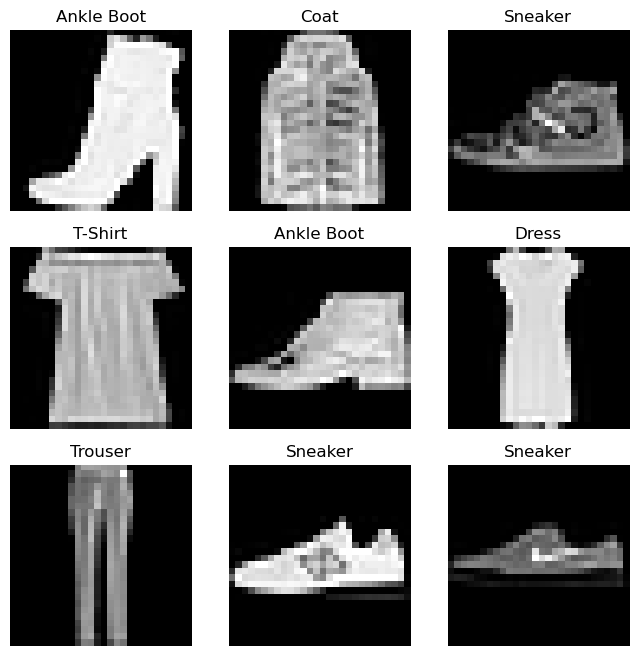

In [23]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

### 2.3 - Creating a custom dataset for your files


Below is an example of a custom dataset class; the FashionMNIST images are stored in a directory `img_dir`, and their labels are stored separately in a CSV file `annotations_file`.

A custom dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`:

- The `__init__` function is run when initializing the dataset object.
- The `__len__` function returns the number of samples in the dataset.
- The `__getitem__` function loads and returns a sample from the dataset at a given index, `idx`.


In [24]:
import os
import pandas as pd
from torchvision.io import decode_image


class CustomImageDataset(Dataset):
    def __init__(
        self, annotations_file, img_dir, transform=None, target_transform=None
    ):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### 2.4 - Preparing your data for training with `DataLoaders`


The `Dataset` retrieves features and labels from a dataset one sample at a time. When training a model, we want to pass samples in minibatches, reshuffle the data at each epoch, and use Python's `multiprocessing` to speed up data retrieval. `DataLoader` abstracts this complexity away for us.


In [25]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Once we have loaded a dataset into the `DataLoader`, we can iterate through the dataset as needed. Each iteration below returns a batch of `train_features` and `train_labels`.


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


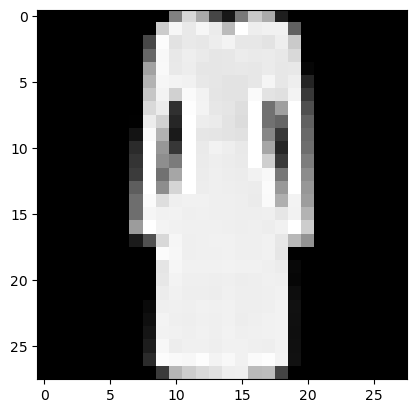

Label: 3


In [26]:
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]

plt.imshow(img, cmap="gray")
plt.show()

print(f"Label: {label}")

---

## 3 - Transforms


Transforms manipulate the data to make it suitable for training. TorchVision datasets have two parameters; `transform` modifies the features, and `target_transform` modifies the label.

For training, we need to convert the features (images) of the FashionMNIST dataset to tensors, and the labels (integers) to one-hot encoded tensors. We do these transformations using `ToTensor` and `Lambda`. `ToTensor()` converts a PIL image, or a NumPy `ndarray`, to a `FloatTensor`. Lambda transforms apply any user-defined lambda function. Below, we define a function to turn the integer into a one-hot encoded tensor.


In [27]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(
        lambda y: torch.zeros(10, dtype=torch.float).scatter_(
            0, torch.tensor(y), value=1
        )
    ),
)

---

## 4 - Building neural networks


Neural networks are comprised of layers/modules that perform operations on data. The `torch.nn` module provides all of the building blocks necessary to build a neural network. In this section, we will build a neural network to classify images in the FashionMNIST dataset.


Import required modules.


In [28]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 4.1 - Getting a device for training


We want to train our model on the GPU.


In [29]:
# Set device to MPS if available, otherwise CPU.
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using {device} device.")

Using mps device.


### 4.2 - Defining the class


We define the neural network by subclassing `nn.Module`, and we initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements operations on data in the `forward` method.


In [30]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We will now create an instance of `NeuralNetwork` and move it to the `device`.


In [31]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it input data. This executes `forward`, as well as background operations. If we pass the output from the model through the `nn.Softmax` module, we can get predicted probabilities.


In [32]:
input_data = torch.rand(1, 28, 28).to(device)
logits = model(input_data)
predicted_probabilities = nn.Softmax(dim=1)(logits)
y_predicted = predicted_probabilities.argmax(1)
print(f"Predicted class: {y_predicted}")

Predicted class: tensor([1], device='mps:0')


### 4.3 - Model layers


We will take a minibatch of 3 images and pass them through the network.


In [33]:
input_images = torch.rand(3, 28, 28)
print(input_images.shape)

torch.Size([3, 28, 28])


The `nn.Flatten` layer converts all of the 28x28 images into a contiguous array of pixel values.


In [34]:
flatten = nn.Flatten()
flattened_images = flatten(input_images)
print(flattened_images.shape)

torch.Size([3, 784])


The `nn.Linear` layer applies a linear transformation to the input using the stored weights and biases.


In [35]:
layer_1 = nn.Linear(in_features=28 * 28, out_features=20)
hidden_1 = layer_1(flattened_images)
print(hidden_1.shape)

torch.Size([3, 20])


Non-linearity allows the model to create complex mappings between inputs and outputs. We will apply a non-linear transformation after the linear transformation. In this model, we ise the `nn.ReLU` activation, which is essentially a step function.


In [36]:
hidden_1_relu = nn.ReLU()(hidden_1)
print(hidden_1_relu.shape)

torch.Size([3, 20])


`nn.Sequential` is an ordered container of modules. The data is passed through the modules in the order defined.


In [37]:
seq_modules = nn.Sequential(flatten, layer_1, nn.ReLU(), nn.Linear(20, 10))
input_images = torch.rand(3, 28, 28)
logits = seq_modules(input_images)
print(logits.shape)

torch.Size([3, 10])


### 4.4 - `nn.Softmax`


The last linear layer of the neural network returns `logits`, raw values in the range $[-\infty, \infty]$. These values are passed to the `nn.Softmax` module, which scales the output to the range $[0, 1]$, representing the model's predicted probabilities. The `dim` parameter in the `nn.Softmax` module indicates the dimension along which all values must sum to 1.


In [38]:
softmax = nn.Softmax(dim=1)
predicted_probabilities = softmax(logits)
print(predicted_probabilities.shape)

torch.Size([3, 10])


### 4.5 - Model parameters


Many layers inside a neural network are parameterized, i.e. they have weights and biases which are optimized during training. Below, we iterate over the parameters and print their shapes.


In [39]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Shape: {param.shape}")

Layer: linear_relu_stack.0.weight | Shape: torch.Size([512, 784])
Layer: linear_relu_stack.0.bias | Shape: torch.Size([512])
Layer: linear_relu_stack.2.weight | Shape: torch.Size([512, 512])
Layer: linear_relu_stack.2.bias | Shape: torch.Size([512])
Layer: linear_relu_stack.4.weight | Shape: torch.Size([10, 512])
Layer: linear_relu_stack.4.bias | Shape: torch.Size([10])


---

## 5 - Automatic differentiation with `torch.autograd`


When training neural networks, the most frequently used algorithm is back propagation. In this algorithm, parameters are adjusted according to the gradient of the loss function. PyTorch has a built-in differentiation engine called `torch.autograd`.


Import required modules.


In [40]:
import torch

We will define a simple, one-layer neural network, with inputs `x`, parameters `w`, biases `b`, and a loss function. We will also define an expected output, `y`.


In [41]:
x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

### 5.1 - Tensors, functions and computational graphs


`w` and `b` are parameters which we need to optimize, and so we need to compute gradients of the loss function with respect to these variables. In order to do this, we need to set the `requires_grad` property of these tensors to `True`.

A function that we apply to tensors to construct a computational graph is an instance of the `Function` class. This object knows how to compute the function in the forwards direction, and how to compute its derivative in the backpropagation step.


In [42]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x31a31b610>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x307eeb070>


### 5.2 - Computing gradients


To optimize weights in the neural network, we need to compute derivatives of the loss function. We can compute $\frac{\partial(loss)}{\partial w}$ and $\frac{\partial(loss)}{\partial b}$ by calling `loss.backward()`. We can retrieve the derivatives using `w.grad` and `b.grad`.


In [43]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2558, 0.0016, 0.0347],
        [0.2558, 0.0016, 0.0347],
        [0.2558, 0.0016, 0.0347],
        [0.2558, 0.0016, 0.0347],
        [0.2558, 0.0016, 0.0347]])
tensor([0.2558, 0.0016, 0.0347])


We can stop tracking computations by surrounding code with the `torch.no_grad()` block, or by using the `detach()` method.


In [44]:
z = torch.matmul(x, w) + b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w) + b
print(z.requires_grad)

True
False


In [45]:
z = torch.matmul(x, w) + b
z_det = z.detach()
print(z_det.requires_grad)

False


---

## 6 - Optimizing model parameters


Once we have a model and data, we can train the model (i.e. optimize the model's parameters using our data). Training is an iterative process. One iteration involves computing the output, evaluating the loss, calculating derivatives of the loss with respect to the parameters, and optimizing these parameters using gradient descent.


Load the prerequisite code.


In [46]:
from send2trash import TrashPermissionError
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork()

### 6.1 - Hyperparameters


Hyperparameters are adjustable parameters that let you control the optimization (training) process. We use the following hyperparameters:

- Number of epochs - the number of times to iterate over the dataset.
- Batch size - the number of samples propagated through the network before we update the parameters.
- Learning rate - how much to update model parameters by after each batch.


In [47]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

### 6.2 - The optimization loop


Once we have set our hyperparameters, we can train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an epoch. Each epoch consists of two main parts:

- The train loop - iterate over the training dataset, and optimize the parameters.
- The test loop - iterate over the test dataset, and check if model performance is improving.


### 6.3 - Loss functions


A loss function measures how close the output from the model is to the target; in training, we try to minimize the loss function. Common loss functions include `nn.MSELoss` for regression tasks, and `nn.NLLLoss` for classification; `nn.CrossEntropyLoss` combines `nn.LogSoftmax` and `nn.NLLLoss`.


Initialize the loss function.


In [48]:
loss_function = nn.CrossEntropyLoss()

### 6.4 - Optimizers


Optimization is when we adjust model parameters to minimize loss. The optimization logic is encapsulated in the `optimizer` object; in this example, we use the Stochastic Gradient Descent (SGD) optimization algorithm.


Initialize the optimizer.


In [49]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In the training loop, optimization happens in three steps:

- Call `optimizer.zero_grad()` to reset the gradients of model parameters.
- Backpropagate the loss, and the gradients of the loss with respect to the parameters, with `loss.backward()`.
- Call `optimizer.step()` to adjust the parameters by the gradients collected in the backwards pass.


### 6.5 - Full implementation


Define the train loop.


In [50]:
def train_loop(dataloader, model, loss_function, optimizer):
    # Set the model to training mode.
    model.train()

    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss.
        prediction = model(X)
        loss = loss_function(prediction, y)

        # Perform backpropagation.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

Define the test loop.


In [ ]:
def test_loop(dataloader, model, loss_function):
    # Set the model to evaluation mode.
    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # torch.no_grad() ensures that no gradients are computed during testing.
    with torch.no_grad():
        for X, y in dataloader:
            prediction = model(X)
            test_loss += loss_function(prediction, y).item()
            correct += (prediction.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%; average loss: {test_loss:>8f}. \n")

Perform the optimization loop.


In [52]:
for t in range(epochs):
    print(f"Epoch {t+1}\n----------------------------------------")
    train_loop(train_dataloader, model, loss_function, optimizer)
    test_loop(test_dataloader, model, loss_function)

Epoch 1
----------------------------------------
Accuracy: 41.5%; average loss: 2.136945. 

Epoch 2
----------------------------------------
Accuracy: 57.2%; average loss: 1.852781. 

Epoch 3
----------------------------------------
Accuracy: 61.3%; average loss: 1.490353. 

Epoch 4
----------------------------------------
Accuracy: 63.3%; average loss: 1.239557. 

Epoch 5
----------------------------------------
Accuracy: 64.8%; average loss: 1.082672. 



---

## 7 - Saving and loading models


Import required modules.


In [53]:
import torch
import torchvision.models as models

The learned parameters are saved in an internal state dictionary, `state_dict`. These parameters can be saved using the `torch.save()` method.


In [54]:
model = models.vgg16(weights="IMAGENET1K_V1")
torch.save(model.state_dict(), "model_weights.pth")

To load model parameters, you need to first create an instance of the same model, and then load the parameters using the `load_state_dict()` method.


In [56]:
model = models.vgg16()
model.load_state_dict(torch.load("model_weights.pth", weights_only=True))

<All keys matched successfully>